# Spiking of Retinal Ganglion Cells of the Goldfish

In [17]:
load('Retinal_ISIs.mat')

## Question 1: Spike Train Time Series and Interspike Interval Histogram

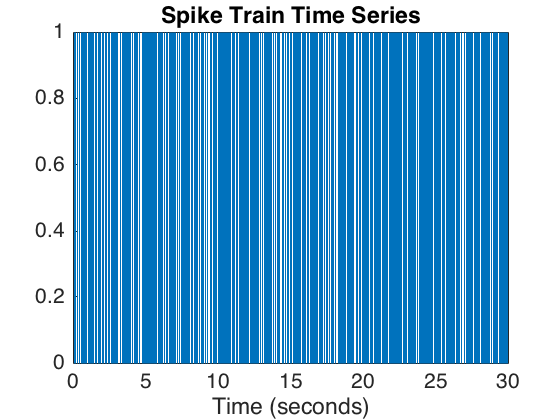

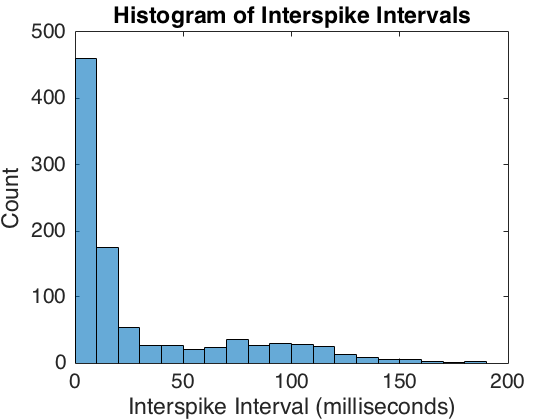

In [18]:
numSpikes = length(ISIs);
fullTime = 30; % 30 seconds of data

spikeTimes = cumsum(ISIs)./1000; % convert to seconds
figure();histogram(ISIs);title('Histogram of Interspike Intervals');
xlabel('Interspike Interval (milliseconds)');
ylabel('Count');

figure();stem(spikeTimes,1.5.*ones(numSpikes,1),'LineWidth',0.1);axis([0 30 0 1]);
title('Spike Train Time Series');xlabel('Time (seconds)');

### This neuron spikes quite regularly, with most of the interspike intervals having duration less than 30 milliseconds. The spike train time series is very uninformative due to the density of the action potentials in time. A rough estimate of this neuron's average firing rate would be ~20 Hz, or one spike every 50 milliseconds. The interval between spikes does not exceed 200 milliseconds, so the lowest possible instantaneous firing rate is 5 Hz. We know that for a homogeneous Poisson process, the interspike interval distribution should be exponential. It's difficult to say by eye, but this distribution does not appear to be exponential. In particular, the counts in the range from ~40 to 120 milliseconds are roughly equal, with a small bump in counts around 100 milliseconds. This does not fit a model of exponential decay.

## Question 2: 5-number Summary and Boxplot

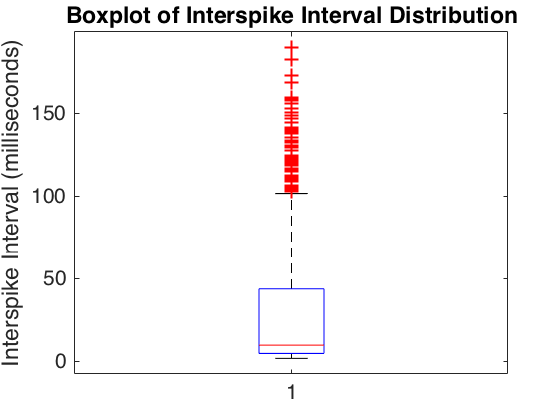

5-number Summary of ISIs (milliseconds):
Minimum = 2.00, 0.25 Quantile = 5.00, Median = 10.00,
 0.75 Quantile = 44.00, Maximum = 190.00


In [3]:
%% Minimum, 0.25 quantile, median, 0.75 quantile, maximum
fiveNums = [min(ISIs),quantile(ISIs,0.25),quantile(ISIs,0.5),quantile(ISIs,0.75),max(ISIs)];
display(sprintf('5-number Summary of ISIs (milliseconds):\nMinimum = %3.2f, 0.25 Quantile = %3.2f, Median = %3.2f,\n 0.75 Quantile = %3.2f, Maximum = %3.2f',fiveNums(1),fiveNums(2),fiveNums(3),fiveNums(4),fiveNums(5)));

%% Boxplot
boxplot(ISIs);title('Boxplot of Interspike Interval Distribution')
ylabel('Interspike Interval (milliseconds)');

### These statistics confirm the obvious fact from the histogram above that most of the ISIs occur below 30 milliseconds. However, this provides a more fine estimation of the crude guess from the histogram. In fact, 50% of the interspike intervals are less than 10 milliseconds. Half of the ISIs are between 2 and 10 milliseconds (a range of 8 milliseconds), while the other half covers a range of 180 milliseconds. The boxplot also shows us that longer interspike intervals are fairly common (Matlab's algorithm to estimate outliers considered a large number of data points to be outliers). We might say the distribution of ISIs is heavy-tailed. Finally, the minimum interspike interval of 2 milliseconds is expected due to the absolute refractory period for neurons.

## Question 3: Discretization of Spike Times into Time Bins (1ms, 10ms, 100ms)

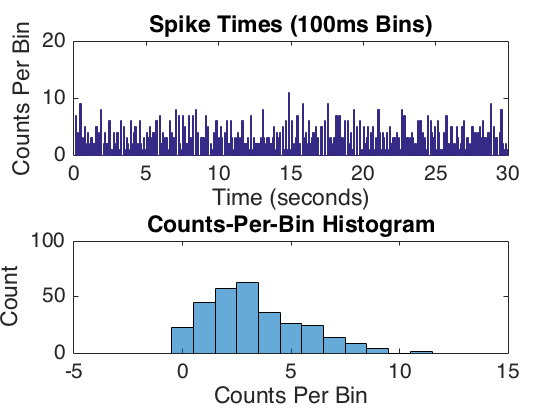

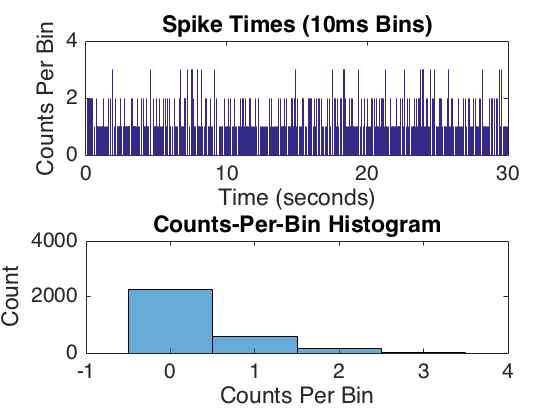

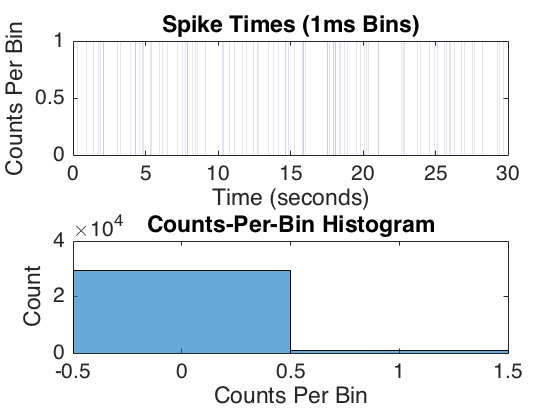

In [4]:
binWidths = [1/1000,10/1000,100/1000];
binTimes = {'1ms','10ms','100ms'};
Time = cell(3,1);
CountsPerBin = cell(3,1);
for ii=1:3
edges = 0:binWidths(ii):30;
numBins = length(edges)-1;
binCenters = edges(1:end-1)+binWidths(ii)/2;
countsPerBin = zeros(numBins,1);
discreteTime = discretize(spikeTimes,edges);
for jj=1:numBins
countsPerBin(jj) = sum(discreteTime==jj);
end
Time{ii} = binCenters;
CountsPerBin{ii} = countsPerBin;
figure();subplot(2,1,1);bar(binCenters,countsPerBin);
title(sprintf('Spike Times (%s Bins)',binTimes{ii}));
xlabel('Time (seconds)');ylabel('Counts Per Bin');
subplot(2,1,2);histogram(countsPerBin);
title('Counts-Per-Bin Histogram');
xlabel('Counts Per Bin');
ylabel('Count');
end


### 100-ms binning clearly violates what would be expected for the increments of a Poisson process. The increments fit a baby Bernoulli distribution, meaning that the probability of a spike in one bin is approximated by a Bernoulli distribution with p = lambda(dt) , where dt is the width of the time bins and lambda is the firing rate. The probability of more than one spike in a given bin should be vanishingly small. For 100-ms binning, we see that 3 counts per time bin is the mode of the distribution, while counts exceeding 10 per bin exist. 10-ms and 1-ms binning more closely approximate what we would expect for a Poisson process. The vast majority of time bins have either zero spikes or one spike. With 10-ms binning, though, there is a small probability of having 3 counts per bin, which violates the rule mentioned above. 1-ms binning provides the most appropriate bin width to match a Poisson process.

## Question 4: Likelihood Function for Homogeneous Poisson Process

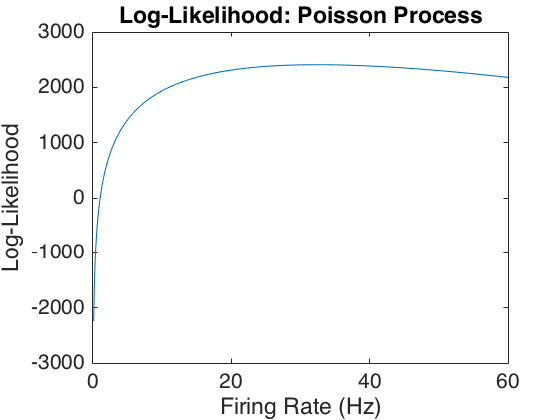

Maximum Likelihood Estimate for Firing Rate Lambda: 32.40 Hz

Approximate 95% Confidence Interval: 30.36 - 34.44 Hz


In [5]:
lambda = 0:0.1:60;
loglikelihood = numSpikes.*log(lambda)-lambda.*fullTime;

figure();plot(lambda,loglikelihood);title('Log-Likelihood: Poisson Process');
xlabel('Firing Rate (Hz)');ylabel('Log-Likelihood');

[~,index] = max(loglikelihood);

lambdaML = lambda(index); % from likelihood function
lambdaML = numSpikes/fullTime; % from calculus

display(sprintf('Maximum Likelihood Estimate for Firing Rate Lambda: %3.2f Hz\n',lambdaML));

fisherInfo = numSpikes/(lambdaML^2);

% 95% Confidence Interval
confInterval = [lambdaML-1.96*sqrt(1/fisherInfo),lambdaML+1.96*sqrt(1/fisherInfo)];
display(sprintf('Approximate 95%% Confidence Interval: %3.2f - %3.2f Hz',confInterval(1),confInterval(2)));

## Question 5: Empirical CDF and KS Plot

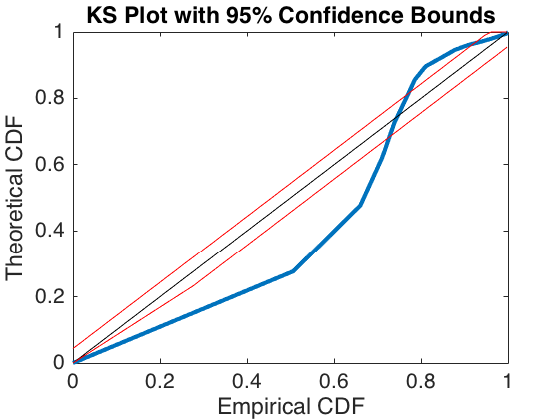

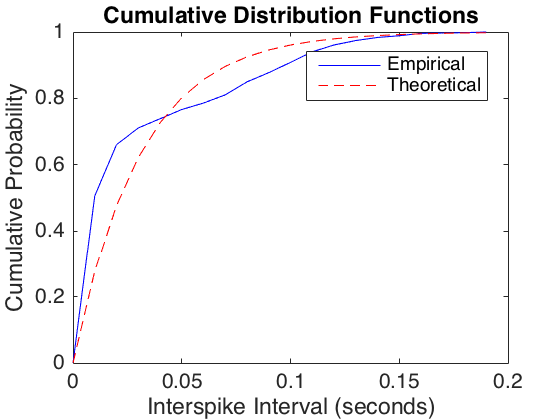

KS statistic: 0.23


In [14]:
sortedISIs = sort(ISIs)./1000;

ISItimes = 0:0.01:max(sortedISIs);
eCDF = zeros(length(ISItimes),1);
for ii=1:length(ISItimes)
eCDF(ii) = sum(sortedISIs<=ISItimes(ii));
end
eCDF = eCDF./numSpikes;

tCDF = 1-exp(-lambdaML.*ISItimes');

figure();
plot(ISItimes,eCDF,'b-');hold on;
plot(ISItimes,tCDF,'r--');
title('Cumulative Distribution Functions');
xlabel('Interspike Interval (seconds)');
ylabel('Cumulative Probability');
legend('Empirical','Theoretical');

bounds = (1.36/sqrt(numSpikes)).*ones(length(ISItimes),1);
figure();plot(eCDF,tCDF,'LineWidth',2);title('KS Plot with 95% Confidence Bounds');
xlabel('Empirical CDF');ylabel('Theoretical CDF');hold on;

plot(tCDF,tCDF,'k');
plot(tCDF,min(tCDF+bounds,1),'r');
plot(tCDF,max(tCDF-bounds,0),'r');hold off;

KSstat = max(abs(eCDF-tCDF));

display(sprintf('KS statistic: %3.2f',KSstat));



### The KS plot shows that the exponential model with rate parameter lambda does not match the data well. The difference between the empirical distribution function and the theoretical one falls beyond the 95% confidence interval for most of the interval.

## Question 6: QQ Plot

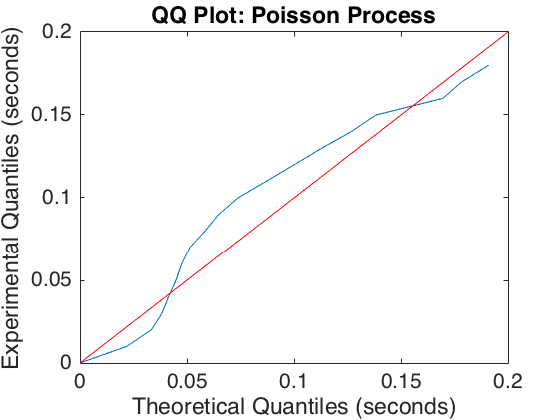

In [7]:
eQ = ISItimes; % empirical quantiles
tQ = expinv(eCDF,1/lambdaML); % theoretical quantiles

figure();plot(tQ,eQ);title('QQ Plot: Poisson Process');
xlabel('Theoretical Quantiles (seconds)');
ylabel('Experimental Quantiles (seconds)');

hold on;
plot(0:0.01:0.2,0:0.01:0.2,'r');


### The QQ plot shows that the empirical CDF deviates from the theoretical one at many interspike intervals. The most significant deviation occurs at about 0.07 seconds, 70 milliseconds. However, significant deviations appear along the entire spread of possible interspike interval times. As shown in the box and whisker plot, it is possible that longer interspike intervals are more probable than would be expected under the assumption of exponential waiting times.

## Question 7: Fano Factor

In [16]:
tFano = 1;
% if the data really comes from a Poisson process, then the sample Fano factor will have a Gamma(n/2,2/n) distribution
alpha = 0.05; % for 95% confidence interval

sampleFano = zeros(3,1);
for ii=1:3
data = CountsPerBin{ii};
numBins = length(data);
sampleVar = var(data);
sampleMean = mean(data);
sampleFano(ii) = sampleVar/sampleMean;
display(sprintf('Sample Fano Factor for %d %s Bins: %3.2f',numBins,binTimes{ii},sampleFano(ii)));
A = numBins/2; % first parameter of gamma
B = 2/numBins; % second parameter of gamma
confInterval = [gaminv(alpha/2,A,B),gaminv(1-alpha/2,A,B)];
display(sprintf('Approximate 95%% Confidence Interval for %d Bins: %3.2f - %3.2f\n',numBins,confInterval(1),confInterval(2)));
end




Sample Fano Factor for 30000 1ms Bins: 0.97
Approximate 95% Confidence Interval for 30000 Bins: 0.98 - 1.02

Sample Fano Factor for 3000 10ms Bins: 1.16
Approximate 95% Confidence Interval for 3000 Bins: 0.95 - 1.05

Sample Fano Factor for 300 100ms Bins: 1.46
Approximate 95% Confidence Interval for 300 Bins: 0.85 - 1.17


### The 95% confidence interval for the sample Fano factor assumes the increments process was generated by a true Poisson process, i.e. if the data were generated by a Poisson process, then the Fano factor will have the above 95% confidence interval. None of the bin sizes yields a result compatible with the interval. For both 10-ms bins and 100-ms bins, the ratio of sample variance to sample mean is greater than what would be expected for a Poisson process.  For 1-ms bins, the sample Fano factor is less than expected. This fits the other analyses performed thus far, where we saw, for example, a dramatic deviation from the exponential distribution in the KS plot.

## Question 8: Autocorrelation Function

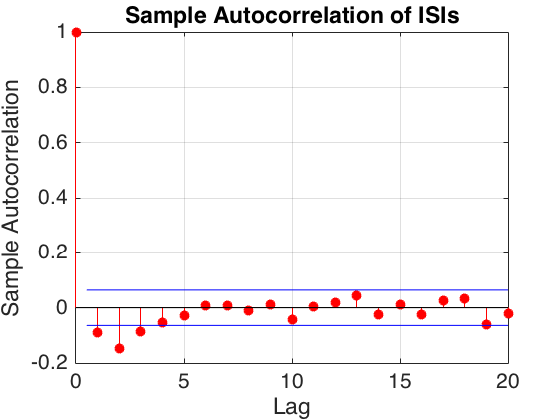

In [9]:
figure();autocorr(ISIs);
title('Sample Autocorrelation of ISIs');

### The autocorrelation plot suggests that the interspike intervals may be correlated up to 3 or 4 lags. Thus, an interspike interval of a certain value, e.g. 10 ms, provides information about the duration of the subsequent interspike interval. The interspike intervals, at least for these lags, are therefore not independent. Perhaps, a long ISI is often followed by a short ISI. Or, short ISIs may often come in bursts so that a single short ISI may be predictive of several upcoming, short ISIs. 

## Question 9: Conclusions

### From the above evaluations, we can conclude that the spontaneous spiking activity of the retinal ganglion neurons was not generated by a homogeneous Poisson process. All of the goodness-of-fit measures revealed significant deviation from theoretical expectation. The KS plot from Question 5 and the autocorrelation function from Question 8 were especially revealing. From the former, we can reject the null hypothesis that the interspike interval distribution is exponential with rate parameter lambda (mean firing rate from Question 4). From the latter, the interspike intervals are not independent. Given that the autocorrelation for lags of one, two, and three fell beyond the 95% confidence bounds for an independent Gaussian process, we might account for the spiking history in order to improve goodness of fit. For example, we can expect a refractory period after a spike. Analysis of the spiking history would reveal that a spike is never followed immediately (< ~1ms) by another spike. In addition, the mode of the distribution of interspike intervals may occur beyond 0 ms, e.g. at 10 ms. Under the assumption of the exponential distrbution for interspike intervals, the most probable interspike interval is 0 ms. The histogram from the beginning seemed not to fit an exponential very well, though it was perhaps improperly binned. Below is a histogram with a different bin size. This histogram reflects the refractory period with very low counts in the first few bins and also the mode greater than 0 ms. More clearly than before, an exponential distribution does not describe this data well.

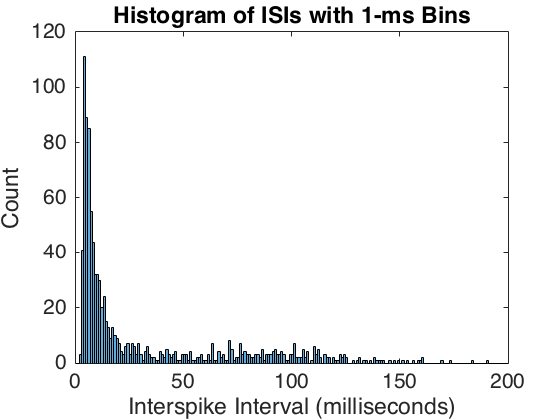

In [10]:
edges = 0:1:200;
figure();histogram(ISIs,edges);
title('Histogram of ISIs with 1-ms Bins');
xlabel('Interspike Interval (milliseconds)');
ylabel('Count');